In [19]:
from sympy import *
init_printing()

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Stiltema (til hele rapporten)
plt.style.use('seaborn-v0_8-whitegrid')

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paths
DATA_PATH          = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv'
VANDSTAND_PATH     = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Raw data/28.02_Vandstand (DMP)_Dag.csv'

# Config
date_col   = 'time'
target_col = 'KarupBro'
input_cols = [
    'temp_min_daily', 'temp_max_daily', 'temp_mean_daily', 
    'temp_grass_mean_daily', 'temp_soil_min_daily', 'temp_soil_max_daily', 
    'temp_soil_mean_daily', 'humidity_daily', 'wind_direction_daily', 
    'wind_speed_daily', 'wind_gust_max_daily', 'precip_total_daily', 
    'precip_duration_daily', 'radiation_global_daily', 
    'sunshine_duration_daily'
]

# 1) Load cleaned & interpolated data
df = pd.read_csv(DATA_PATH, parse_dates=[date_col])
df.sort_values(date_col, inplace=True)
df.set_index(date_col, inplace=True)

# 2) Function to load daily water‐level data
def load_daily_vandstand(path):
    # Find the header line ("Dato (DK normaltid)...")
    with open(path, encoding='latin1') as f:
        for i, line in enumerate(f):
            if line.strip().startswith('Dato (DK normaltid)'):
                header_row = i
                break

    # Read only date and water_level columns
    vand = pd.read_csv(
        path,
        sep=';',
        skiprows=header_row,
        header=0,
        usecols=[0, 1],
        encoding='latin1',
        engine='python'
    )
    # Rename and parse date
    vand.columns = ['date', 'water_level']
    vand['date'] = pd.to_datetime(vand['date'], dayfirst=True)
    vand.set_index('date', inplace=True)
    return vand

# 3) Load and merge water_level
vand_df = load_daily_vandstand(VANDSTAND_PATH)
df = df.join(vand_df['water_level'], how='left')

# 4) Inspect
df.tail()

,temp_min_daily,temp_max_daily,temp_mean_daily,temp_grass_mean_daily,temp_soil_min_daily,temp_soil_max_daily,temp_soil_mean_daily,humidity_daily,wind_direction_daily,wind_gust_max_daily,wind_speed_daily,precip_total_daily,precip_duration_daily,radiation_global_daily,sunshine_duration_daily,KarupBro,ET0,water_level
time,,,,,,,,,,,,,,,,,,
2023-12-20,0.8,4.4,3.141667,2.316667,5.1,5.4,5.241667,88.583333,252.000000,12.2,2.541667,0.4,4.0,349.0,111.0,4448.18,36.289050,8.506
2023-12-21,1.4,8.7,5.316667,4.637500,5.0,5.3,5.141667,86.083333,254.666667,22.5,5.329167,19.9,159.0,270.0,29.5,5602.14,24.390254,8.640
2023-12-22,0.1,4.0,2.395833,1.129167,4.0,5.1,4.533333,66.000000,293.416667,19.1,5.020833,0.6,3.0,749.0,294.5,6636.60,60.468354,8.754
2023-12-23,-1.6,3.3,0.833333,-0.250000,3.6,4.1,3.754167,88.000000,264.000000,10.5,2.379167,0.8,4.0,589.0,247.0,5809.15,56.266438,8.666
2023-12-24,-0.3,2.1,1.120000,0.700000,3.4,3.6,3.520000,97.700000,136.500000,6.6,1.500000,5.0,38.0,9.0,0.0,5197.78,0.986866,8.598


In [21]:
# Replace outliers with NaN
df.loc[df["temp_mean_daily"] > 35, "temp_mean_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["temp_mean_daily"] = df["temp_mean_daily"].ffill()

# Replace outliers with NaN
df.loc[df["precip_total_daily"] > 100, "precip_total_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["precip_total_daily"] = df["precip_total_daily"].ffill()

Text(0.5, 1.0, 'Daily inflow and rainfall')

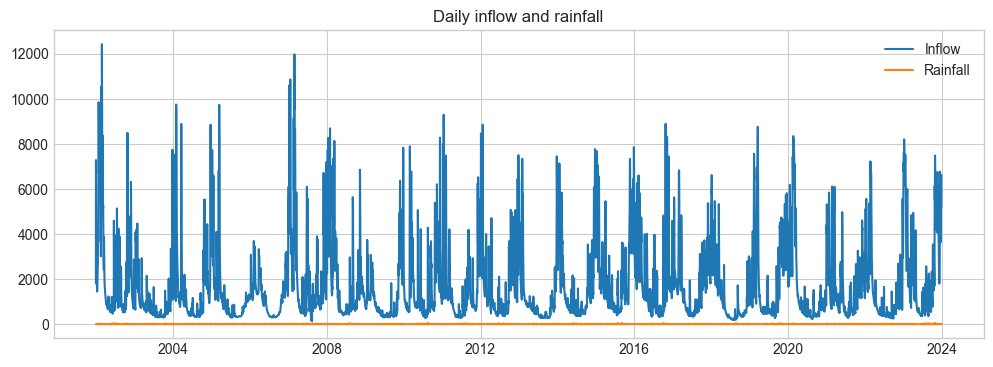

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(df['KarupBro'], label='Inflow')
plt.plot(df['precip_total_daily'], label='Rainfall')
plt.legend(); plt.title('Daily inflow and rainfall')

In [23]:
# Arealet i m²
area_km2 = 178.2
area_m2 = area_km2 * 1e6

# Nedbør i mm → meter
df['precip_m'] = df['precip_total_daily'] / 1000

# Volumen nedbør over oplandet (m³)
df['precip_volume'] = df['precip_m'] * area_m2

df['KarupBro_m3_day'] = df['KarupBro'] * 86.4

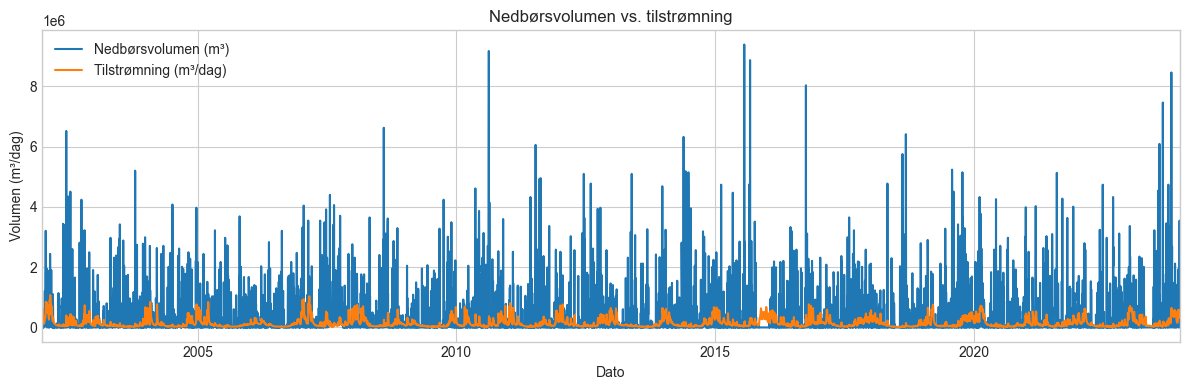

In [24]:
# # only plot the last year
# start_date = df.index[-1] - pd.DateOffset(years=1)
# df = df[df.index >= start_date]

plt.figure(figsize=(12, 4))
df['precip_volume'].plot(label='Nedbørsvolumen (m³)')
df['KarupBro_m3_day'].plot(label='Tilstrømning (m³/dag)')
plt.legend()
plt.title("Nedbørsvolumen vs. tilstrømning")
plt.ylabel("Volumen (m³/dag)")
plt.xlabel("Dato")
plt.tight_layout()
plt.show()

In [25]:
df['precip_3day_avg'] = df['precip_volume'].rolling(window=3).mean()
df['precip_5day_avg'] = df['precip_volume'].rolling(window=5).mean()
df['precip_7day_avg'] = df['precip_volume'].rolling(window=7).mean()
df['precip_14day_avg'] = df['precip_volume'].rolling(window=14).mean()

corr_3 = df['KarupBro_m3_day'].corr(df['precip_3day_avg'])
corr_5 = df['KarupBro_m3_day'].corr(df['precip_5day_avg'])
corr_7 = df['KarupBro_m3_day'].corr(df['precip_7day_avg'])
corr_14 = df['KarupBro_m3_day'].corr(df['precip_14day_avg'])

print(f"Correlation with 3-day avg precip: {corr_3:.2f}")
print(f"Correlation with 5-day avg precip: {corr_5:.2f}")
print(f"Correlation with 7-day avg precip: {corr_7:.2f}")
print(f"Correlation with 14-day avg precip: {corr_14:.2f}")

Correlation with 3-day avg precip: 0.36
Correlation with 5-day avg precip: 0.42
Correlation with 7-day avg precip: 0.42
Correlation with 14-day avg precip: 0.40


In [26]:
df['runoff_ratio'] = df['KarupBro_m3_day'] / df['precip_volume']
df['runoff_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

# compute the mean runoff ratio
mean_runoff_ratio = df['runoff_ratio'].mean()
print(f"Mean runoff ratio: {mean_runoff_ratio:.2f}")

Mean runoff ratio: 1.57


In [27]:
# Test multiple window sizes to find which rolling average gives highest correlation
max_window = 30
rolling_corrs = {}

for window in range(1, max_window + 1):
    colname = f'precip_roll{window}'
    df[colname] = df['precip_volume'].rolling(window=window).mean()
    corr = df['KarupBro_m3_day'].corr(df[colname])
    rolling_corrs[window] = corr

# Find the best window size
best_window = max(rolling_corrs, key=rolling_corrs.get)
best_corr = rolling_corrs[best_window]

# Calculate runoff ratio based on the best moving average
best_avg_col = f'precip_roll{best_window}'
df['runoff_ratio_ma'] = df['KarupBro_m3_day'] / df[best_avg_col]

# Remove infs and NaNs for ratio
df['runoff_ratio_ma'].replace([np.inf, -np.inf], np.nan, inplace=True)
mean_runoff_ratio_ma = df['runoff_ratio_ma'].mean()

best_window, best_corr, mean_runoff_ratio_ma

In [28]:
df['precip_volume_lag1'] = df['precip_volume'].shift(1)
df['runoff_ratio_lag1'] = df['KarupBro_m3_day'] / df['precip_volume_lag1']
df['runoff_ratio_lag1'].replace([np.inf, -np.inf], np.nan, inplace=True)
# compute the mean runoff ratio
mean_runoff_ratio_lag1 = df['runoff_ratio_lag1'].mean()
print(f"Mean runoff ratio lag1: {mean_runoff_ratio_lag1:.2f}")

# lag2
df['precip_volume_lag2'] = df['precip_volume'].shift(2)
df['runoff_ratio_lag2'] = df['KarupBro_m3_day'] / df['precip_volume_lag2']
df['runoff_ratio_lag2'].replace([np.inf, -np.inf], np.nan, inplace=True)
# compute the mean runoff ratio
mean_runoff_ratio_lag2 = df['runoff_ratio_lag2'].mean()
print(f"Mean runoff ratio lag2: {mean_runoff_ratio_lag2:.2f}")

Mean runoff ratio lag1: 1.45
Mean runoff ratio lag2: 1.48


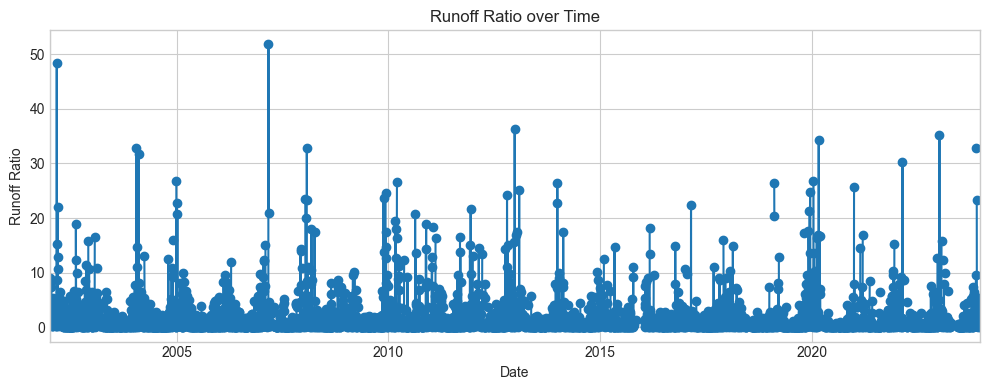

In [29]:
# Plot runoff ratio
plt.figure(figsize=(10, 4))
df['runoff_ratio'].plot(marker='o')
plt.title('Runoff Ratio over Time')
plt.ylabel('Runoff Ratio')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.show()

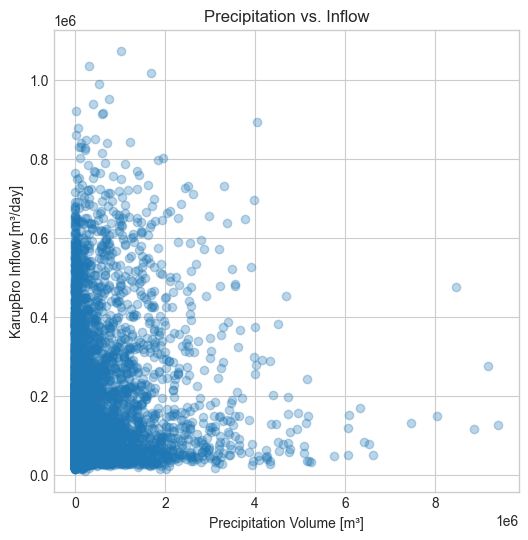

In [30]:
plt.figure(figsize=(6, 6))
plt.scatter(df['precip_volume'], df['KarupBro_m3_day'], alpha=0.3)
plt.xlabel("Precipitation Volume [m³]")
plt.ylabel("KarupBro Inflow [m³/day]")
plt.title("Precipitation vs. Inflow")
plt.grid(True)
plt.show()

In [31]:
for lag in range(1, 11):
    df[f'precip_volume_lag{lag}'] = df['precip_volume'].shift(lag)

correlations = {
    f"Lag {lag}": df['KarupBro_m3_day'].corr(df[f'precip_volume_lag{lag}'])
    for lag in range(1, 11)
}

for k, v in correlations.items():
    print(f"{k}: {v:.2f}")

Lag 1: 0.30
Lag 2: 0.27
Lag 3: 0.23
Lag 4: 0.18
Lag 5: 0.15
Lag 6: 0.12
Lag 7: 0.11
Lag 8: 0.10
Lag 9: 0.10
Lag 10: 0.09


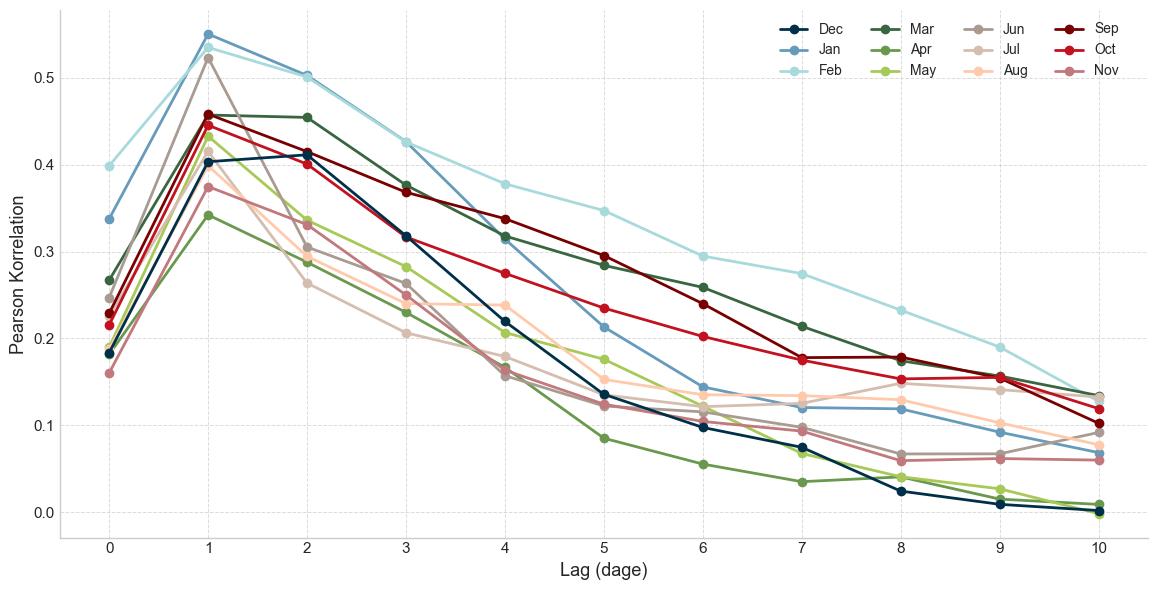

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar

season_shades = {
    "Vinter":   ["#003049", "#669bbc", "#a8dadc"],  # Indigo → Blå nuancer
    "Forår":    ["#386641", "#6A994E", "#a7c957"],  # Mørk → Lys grøn
    "Sommer":   ["#A99B92", "#d5bdaf", "#FFCAAB"],  # Orange → Gul nuance 
    "Efterår":  ["#780000", "#c1121f", "#C1797D"]   # Mørk rød → Orange-rød
}

# Måneder pr. årstid
season_months = {
    "Vinter":   [12, 1, 2],
    "Forår":    [3, 4, 5],
    "Sommer":   [6, 7, 8],
    "Efterår":  [9, 10, 11]
}

# Byg måned → farve mapping
month_colors = {}
for season, months in season_months.items():
    shades = season_shades[season]
    for idx, m in enumerate(months):
        month_colors[m] = shades[idx]

# Sørg for at df.index er DatetimeIndex:
# df['date'] = pd.to_datetime(df['date'])
# df.set_index('date', inplace=True)

max_lag = 10
lags = list(range(max_lag + 1))

# Beregn korrelationer pr. måned
monthly_corrs = {}
for month in range(1, 13):
    df_m = df[df.index.month == month]
    corrs = []
    for lag in lags:
        shifted = df_m['precip_volume'].shift(lag)
        valid = shifted.notna() & df_m['KarupBro_m3_day'].notna()
        corrs.append(df_m.loc[valid, 'KarupBro_m3_day'].corr(shifted[valid]))
    monthly_corrs[month] = corrs

# Plot
plt.figure(figsize=(12, 6))
for month in range(1, 13):
    plt.plot(
        lags,
        monthly_corrs[month],
        marker='o',
        markersize=6,
        linewidth=2,
        color=month_colors[month],
        label=calendar.month_abbr[month]
    )

plt.xlabel("Lag (dage)", fontsize=13)
plt.ylabel("Pearson Korrelation", fontsize=13)
plt.xticks(lags, fontsize=11)
plt.yticks(fontsize=11)
plt.xlim(-0.5, max_lag + 0.5)
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

# Legend i 3×4 grupperet efter årstid
handles, labels = plt.gca().get_legend_handles_labels()
order = [12, 1, 2,   3, 4, 5,   6, 7, 8,   9, 10, 11]  # vinter, forår, sommer, efterår
abbr = calendar.month_abbr
ordered_handles = [handles[labels.index(abbr[m])] for m in order]
ordered_labels  = [abbr[m] for m in order]

plt.legend(
    ordered_handles,
    ordered_labels,
    ncol=4,
    fontsize=10,
    bbox_to_anchor=(0.65, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()


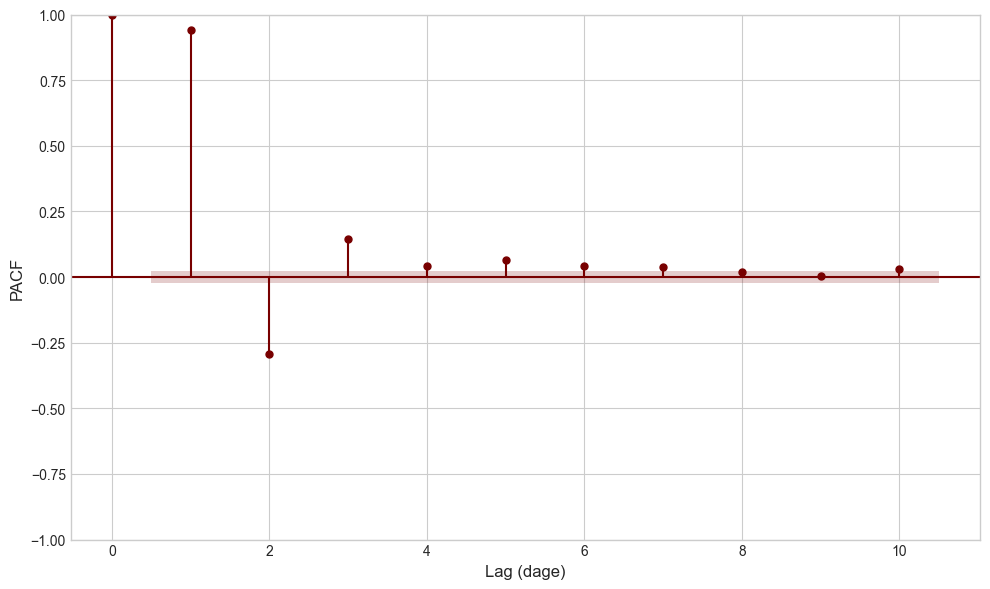

In [77]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.collections import PolyCollection

# Brug samme Tailwind-farve som før
farve = colors["barn_red"]

fig, ax = plt.subplots(figsize=(10, 6))

# Standard PACF-plot med valgt farve og confidence band
plot_pacf(
    df['KarupBro_m3_day'].dropna(),
    lags=10,
    ax=ax,
    color=farve,
    vlines_kwargs={'color': farve},
    alpha=0.05
)

# Sørg for, at CI-båndet får samme farve
for col in ax.collections:
    if isinstance(col, PolyCollection):
        col.set_facecolor(farve)
        col.set_alpha(0.2)
        break

plt.xlabel("Lag (dage)", fontsize=12)
plt.ylabel("PACF", fontsize=12)
plt.title("")
plt.tight_layout()
plt.show()

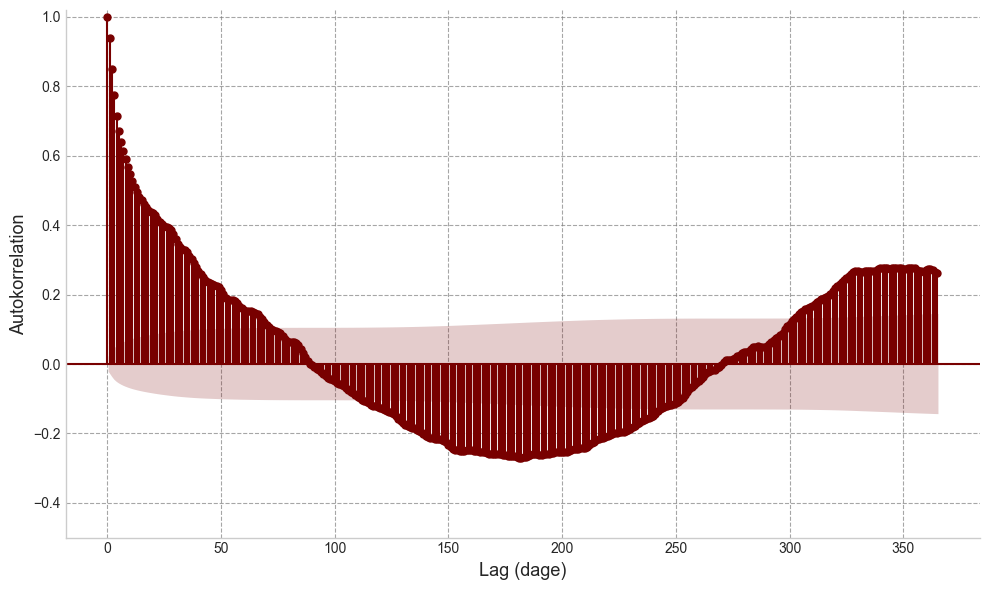

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.collections import PolyCollection

farve = colors["barn_red"]
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(10, 6))

# Tegn ACF med CI-skygge
plot_acf(
    df['KarupBro_m3_day'].dropna(),
    lags=365,
    ax=ax,
    color=farve,
    vlines_kwargs={'color': farve},
    alpha=0.05
)
for col in ax.collections:
    if isinstance(col, PolyCollection):
        col.set_facecolor(farve)
        col.set_alpha(0.2)
        break

# Fjern den gamle titel
ax.set_title("")

# Sæt y-aksens bund til 0, og top til lige over maksimum
y_min, y_max = ax.get_ylim()
ax.set_ylim(-0.5, 1.02)

# Styling
ax.set_xlabel("Lag (dage)", fontsize=13)
ax.set_ylabel("Autokorrelation", fontsize=13)
ax.tick_params()
ax.grid(True, linestyle='--', alpha=0.7, color='grey')
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

In [35]:
df['precip_lag1'] = df['precip_volume'].shift(1)
df['precip_4day_avg'] = df['precip_volume'].rolling(window=4).mean()

# Correlation with inflow
print("Lag-1 corr: ", df['KarupBro_m3_day'].corr(df['precip_lag1']))
print("4-day MA corr: ", df['KarupBro_m3_day'].corr(df['precip_4day_avg']))
print("Combined (lag1 + MA): ", df['KarupBro_m3_day'].corr(df['precip_lag1'] + df['precip_4day_avg']))

Lag-1 corr:  0.30204445853312534
4-day MA corr:  0.39934030319979624
Combined (lag1 + MA):  0.3731233888736774


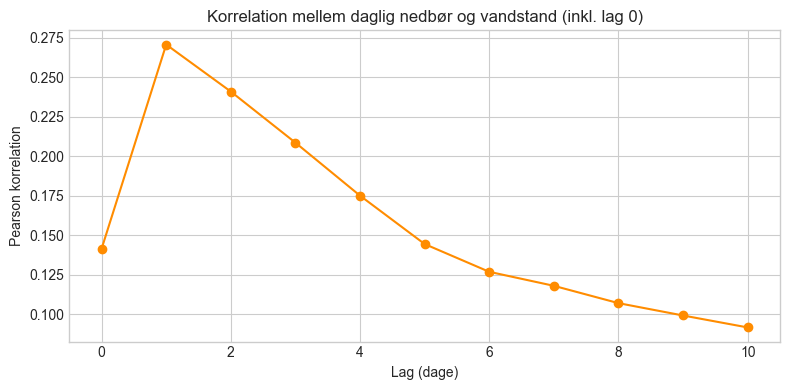

In [36]:
import matplotlib.pyplot as plt

# Vælg max lag i dage
max_lag = 10
lags = list(range(max_lag + 1))
correlations = []

# Loop over lag 0…max_lag
for lag in lags:
    shifted_precip = df['precip_total_daily'].shift(lag)
    valid = shifted_precip.notna() & df['water_level'].notna()
    corr = df.loc[valid, 'water_level'].corr(shifted_precip[valid])
    correlations.append(corr)

# Plot korrelation vs. lag
plt.figure(figsize=(8, 4))
plt.plot(lags, correlations, marker='o', color='darkorange')
plt.title("Korrelation mellem daglig nedbør og vandstand (inkl. lag 0)")
plt.xlabel("Lag (dage)")
plt.ylabel("Pearson korrelation")
plt.grid(True)
plt.tight_layout()
plt.show()